<a href="https://colab.research.google.com/github/Clamepending/KamaroAutonomousRCcar/blob/main/ColabToSendV1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.layers import UpSampling2D
import matplotlib.pyplot as plt
import time
import pickle
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Reshape, Add
from tensorflow.keras.layers import Conv2DTranspose, DepthwiseConv2D, GlobalAveragePooling2D, Input
from tensorflow.keras.callbacks import TensorBoard
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive')

# Commonly used modules
import numpy as np
import os
import sys

# Images, plots, display, and visualization
import matplotlib.pyplot as plt

print(tf.__version__)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
2.5.0


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
   raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print(tf.version)

Found GPU at: /device:GPU:0
<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.7/dist-packages/tensorflow/_api/v2/version/__init__.py'>


In [ ]:
pickle_in = open("/content/drive/MyDrive/RGB_and_Depth_Data/PickleData/x_train.pickle", "rb")
x_train = pickle.load(pickle_in)

pickle_in = open("/content/drive/MyDrive/RGB_and_Depth_Data/PickleData/y_train.pickle", "rb")
y_train = pickle.load(pickle_in)

pickle_in = open("/content/drive/MyDrive/RGB_and_Depth_Data/PickleData/x_test.pickle", "rb")
x_test = pickle.load(pickle_in)

pickle_in = open("/content/drive/MyDrive/RGB_and_Depth_Data/PickleData/y_test.pickle", "rb")
y_test = pickle.load(pickle_in)

(2925, 90, 160, 3)


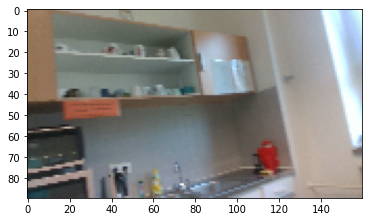

In [ ]:
plt.imshow(x_test[4])
print(x_train.shape)

In [ ]:
#Build the model
dropout = 0.2
input = tf.keras.Input(shape=x_train[0].shape)
pool1 = Conv2D(32, (2, 2), padding='same', activation='relu')(input)
pool1 = MaxPooling2D(pool_size=(2,2))(pool1)
pool1 = Conv2D(48, (4, 4), padding='same', activation='relu')(pool1)
pool1 = MaxPooling2D(pool_size=(1,2))(pool1)

pool1 = Conv2D(96, kernel_size=(5, 5), activation='relu', padding='same')(pool1)
pool1 = Dropout(dropout)(pool1)
pool1 = MaxPooling2D(pool_size=(3, 2))(pool1)

pool2 = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same')(pool1)
pool2 = Dropout(dropout)(pool2)
pool2 = MaxPooling2D(pool_size=(1, 2))(pool2)

pool3 = Conv2D(384, (3, 3), activation='relu', padding='same')(pool2)
pool3 = Dropout(dropout)(pool3)
pool3 = Conv2D(384, (3, 3), activation='relu', padding='same')(pool3)
pool3 = Dropout(dropout)(pool3)
pool3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
pool3 = Dropout(dropout)(pool3)
pool3 = MaxPooling2D(pool_size=(3, 2))(pool3)


pool4 = Conv2D(4096, (3, 3), activation='relu', padding="same")(pool3)
pool4 = Dropout(dropout)(pool4)
pool4 = Conv2D(4096, (3, 3), activation='relu', padding="same")(pool4)
pool4 = Dropout(dropout)(pool4)
pool4 = Conv2D(21, (3, 3), activation='relu', padding="same")(pool4)
pool4 = Dropout(dropout)(pool4)
pool4 = UpSampling2D(size=(18, 32))(pool4)

pool1 = Dense(1, activation='relu')(pool1)
pool2 = Dense(1, activation='relu')(pool2)
pool3 = Dense(1, activation='relu')(pool3)
pool4 = Dense(1, activation='relu')(pool4)

fusionLayer = UpSampling2D(size=(3, 2))(pool3)

fusionLayer = Add()([pool2, fusionLayer])

fusionLayer = UpSampling2D(size=(1, 2))(fusionLayer)

fusionLayer = Add()([pool1, fusionLayer])

fusionLayer = UpSampling2D(size=(6, 8))(fusionLayer)

fusionLayer = Add()([pool4, fusionLayer])

print(fusionLayer.shape)

model = tf.keras.models.Model(inputs=input, outputs=fusionLayer)

model.summary()

(None, 90, 160, 1)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 90, 160, 3)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 90, 160, 32)  416         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 45, 80, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 45, 80, 48)   24624       max_pooling2d[0][0]              
___________________________________________________________________________

In [ ]:
NAME = "depth-cnn-output-dense-" + str(time.time())
#tensorboard = TensorBoard(log_dir="C:/Users/sotao/Desktop/Data/logs/" + NAME)

#model.load_weights("C:/Users/sotao/Desktop/Data/Checkpoints/depth-cnn-output-dense-1627746842.3250527") #FIND THE NAME
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath= "C:/Users/sotao/Desktop/Data/Checkpoints/" + NAME,
#     monitor='val_loss',
#     save_best_only = False,
#     verbose = 1,
#     save_weights_only = True)

model.compile(optimizer=tf.keras.optimizers.Adam(0.0005),
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

history = model.fit(x_train, y_train, epochs=1, validation_split = 0.2, shuffle = True, callbacks=[tensorboard])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


74/74 [==============================] - 100s 845ms/step - loss: 5364178.0000 - root_mean_squared_error: 2316.0696 - val_loss: 6562463.0000 - val_root_mean_squared_error: 2561.7305


11/11 - 2s - loss: 2258069.5000 - root_mean_squared_error: 1502.6874


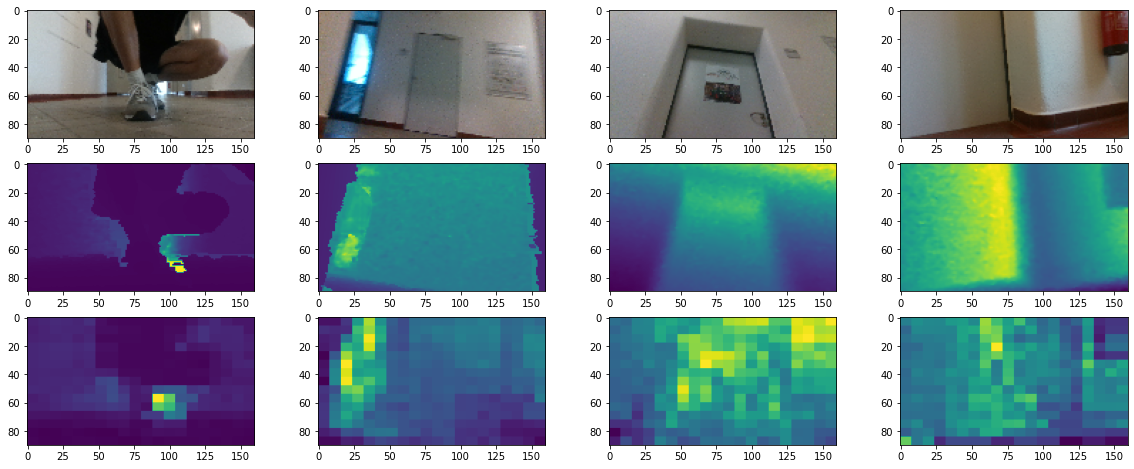

In [ ]:
plt.figure(figsize=(20,8))
plt.subplot(3,4,1)
plt.imshow(x_test[10])
plt.subplot(3,4,5)
plt.imshow(y_test[10])
plt.subplot(3,4,9)
plt.imshow(model.predict(x_test)[10,:, :, 0])

plt.subplot(3,4,2)
plt.imshow(x_test[20])
plt.subplot(3,4,6)
plt.imshow(y_test[20])
plt.subplot(3,4,10)
plt.imshow(model.predict(x_test)[20,:, :, 0])

plt.subplot(3,4,3)
plt.imshow(x_test[40])
plt.subplot(3,4,7)
plt.imshow(y_test[40])
plt.subplot(3,4,11)
plt.imshow(model.predict(x_test)[40,:, :, 0])

plt.subplot(3,4,4)
plt.imshow(x_test[50])
plt.subplot(3,4,8)
plt.imshow(y_test[50])
plt.subplot(3,4,12)
plt.imshow(model.predict(x_test)[50,:, :, 0])

test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

In [ ]:
model.save('C:/Users/sotao/Desktop/Data/models/'+ NAME)

C:\Users\sotao\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: C:/Users/sotao/Desktop/Data/models/depth-cnn-output-dense-1627911647.6281774\assets


In [ ]:
new_model = tf.keras.models.load_model('C:/Users/sotao/Desktop/Data/models/depth-cnn-output-dense-1627911647.6281774')

NAME = "depth-cnn-output-dense-" + str(time.time())
tensorboard = TensorBoard(log_dir="C:/Users/sotao/Desktop/Data/logs/" + NAME)

#model.load_weights("C:/Users/sotao/Desktop/Data/Checkpoints/depth-cnn-output-dense-1627746842.3250527") #FIND THE NAME
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath= "C:/Users/sotao/Desktop/Data/Checkpoints/" + NAME,
#     monitor='val_loss',
#     save_best_only = False,
#     verbose = 1,
#     save_weights_only = True)

new_model.compile(optimizer=tf.keras.optimizers.Adam(0.0005),
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

history = new_model.fit(x_train, y_train, epochs=1000, validation_split = 0.2, shuffle = True, callbacks=[tensorboard])

C:\Users\sotao\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/1000
74/74 [==============================] - 94s 1s/step - loss: 821858.5625 - root_mean_squared_error: 906.5642 - val_loss: 3160486.7500 - val_root_mean_squared_error: 1777.7756
Epoch 2/1000
74/74 [==============================] - 79s 1s/step - loss: 804979.5000 - root_mean_squared_error: 897.2064 - val_loss: 3132858.0000 - val_root_mean_squared_error: 1769.9882
Epoch 3/1000
74/74 [==============================] - 79s 1s/step - loss: 805443.6250 - root_mean_squared_error: 897.4651 - val_loss: 3166318.5000 - val_root_mean_squared_error: 1779.4152
Epoch 4/1000
74/74 [==============================] - 79s 1s/step - loss: 808016.4375 - root_mean_squared_error: 898.8973 - val_loss: 3148345.0000 - val_root_mean_squared_error: 1774.3577
Epoch 5/1000
74/74 [==============================] - 79s 1s/step - loss: 811073.8125 - root_mean_squared_error: 900.5964 - val_loss: 3210055.0000 - val_root_mean_squared_error: 1791.6627
Epoch 6/1000
74/74 [==============================] - 79s 1s

In [ ]:
!pip install tensorflow_model_optimization
import tensorflow_model_optimization as tfmot

     |████████████████████████████████| 211 kB 4.2 MB/s 


In [ ]:
#quantize model
print(model.input.shape)
tfmot.quantization.keras.quantize_model(model)

# #compile quantized model
# q_aware_model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.RootMeanSquaredError()])

# #display quantized model
# q_aware_model.summary()

# quant_tensorboard = TensorBoard(log_dir="logs-quant/" + NAME)

# #train quantized model
# q_aware_model.fit(x_train, y_train, epochs=10, validation_split = 0.2,shuffle = True, verbose = 2, callbacks = [quant_tensorboard])

# #evaluate quantized model
# q_aware_model.evaluate(x_test, y_test)

(None, 90, 160, 3)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


ValueError: ignored

In [ ]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model('C:/Users/sotao/Desktop/Data/models/depth-cnn-output-dense-1627911647.6281774') # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('testModel.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model('C:/Users/sotao/Desktop/Data/models/depth-cnn-output-dense-1627911647.6281774')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = x_train[:50]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8
tflite_quant_model = converter.convert()
with open('QuantizedModel.tflite', 'wb') as f:
  f.write(tflite_model)

TypeError: 'numpy.bool_' object is not callable